<a href="https://colab.research.google.com/github/ferjorosa/learn-fastai/blob/main/basic_mnist_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic MNIST example**

The objective of this notebook is to simply put my notes and examples of the MNIST example of Chapter 4 from the Fast AI book

**Note:** Im not completely sure that I have perfectly followed the implementation of Fast AI book because it dones not work as good. Howver, after several tests I have come to the conclusion that the SGD implementation from Pytorch may be the main difference (although i cannot assure that my validation implementation is fully correct)

### Installation

In [66]:
#hide (Google Colab)
!pip install fastai --upgrade -q
import fastai
print(fastai.__version__)

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

2.5.3


In [67]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

### **Data**

In [68]:
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [69]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [70]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [71]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### **Single-batch gradient descent**

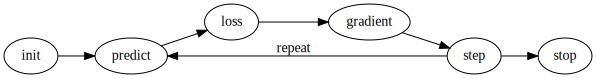

In [72]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [73]:
train_x =torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([0] * len(stacked_threes) + [1] *len(stacked_sevens)).unsqueeze(1)
(train_x.shape, train_y.shape)

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [74]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1,28*28)
valid_y = tensor([0] * len(valid_3_tens) + [1] * len(valid_7_tens)).unsqueeze(1)
(valid_x.shape, valid_y.shape)

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [101]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

def mnist_loss(predictions, targets): 
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def linear3(x, w): return x@w + intercept
  
def predict(x, w):
  linear_predictions = model(x, w)
  predictions = linear_predictions.sigmoid()
  return torch.where(predictions > 0.5, 1, 0)

def validate(valid_x, w, valid_y):
  binary_preds = predict(valid_x, w)
  return (binary_preds == valid_y).count_nonzero() / valid_y.shape[0]

def epoch1(x, y, w, valid_x, valid_y, prt=True):
  pred = model(x, w)
  loss = mnist_loss(pred, y)
  loss.backward()
  if prt: print("Loss: " + str(loss))
  accuracy = validate(valid_x, w, valid_y)
  if prt: print("Validation accuracy: " + str(accuracy))
  w.data -= w.grad * lr

w = init_params((784, 1))
lr = 1e-3
model = linear3
weights = init_params((28*28,1))
intercept = init_params(1)

In [102]:
epoch1(train_x, train_y, w, valid_x, valid_y)

Loss: tensor(0.3155, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.7090)


In [104]:
n_epochs = 5
for i in range (1, n_epochs):
  epoch1(train_x, train_y, w, valid_x, valid_y)

Loss: tensor(0.3151, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.7100)
Loss: tensor(0.3149, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.7100)
Loss: tensor(0.3147, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.7100)
Loss: tensor(0.3145, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.7100)


### **Stochastic gradient descent**

When working with gradient descent it may be interesting to consider only a hadful of batches at each iteration. We can do this with Fast AI in a ver simple
manner with the *DataLoader* class.

In the following implementation, each epoch considers all of the data. However, **each epoch updates the parameters multiple times** by considering all of the data in batch form in random order. 

**Note on theory:** I am not completely sure this is the traditional way of doing SGD, but it was the intuition I obtained from reading the AI book

**Note on speed:** Previous implementation is much faster. I suppose due to the absence of the multiple for loops that are here

In [105]:
train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(train_x, train_y))

In [106]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
xb, yb = first(train_dl)
print(xb.shape, yb.shape)

valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)
xb, yb = first(valid_dl)
print(xb.shape, yb.shape)

torch.Size([256, 784]) torch.Size([256, 1])
torch.Size([256, 784]) torch.Size([256, 1])


In [90]:
class LinearModel:

  def __init__(self, intercept, weights):
    self.intercept = intercept
    self.weights = weights
    self.params = (intercept, weights)

  def predict(self, data):
    return data@self.weights + self.intercept


def mnist_loss(predictions, targets): 
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def calc_grad(xb, yb, model, prt=True):
  pred = model.predict(xb)
  loss = mnist_loss(pred, yb)
  loss.backward()
  if prt: print("Loss: " + str(loss))

def train_epoch(train_dl, model, lr, prt=True):
  for xb, yb in train_dl: # Iterates over batches, not individual instances
    calc_grad(xb, yb, model, prt)
    for p in model.params:
      p.data -= p.grad * lr
      p.grad.zero_() # See page 172, last paragraph
  
def hard_predict_mnist(xb, model):
  linear_predictions = model.predict(xb)
  predictions = linear_predictions.sigmoid()
  return torch.where(predictions > 0.5, 1, 0)

def validate_epoch(valid_dl, model):
  batch_accs = [(hard_predict_mnist(valid_xb, model) == valid_yb).count_nonzero() 
                / valid_yb.shape[0] for valid_xb, valid_yb in valid_dl]
  return torch.FloatTensor(batch_accs).mean()

In [81]:
# Small example just to see what was happening under the hood
# xb and yb are now batches, not individual data instances

# l = []
# for xb, yb in train_dl:
#   l.append(xb)
# len(l)

In [94]:
weights = init_params((28*28,1))
intercept = init_params(1)
linear_model = LinearModel(intercept, weights)
n_epochs=5 

for i in range(1, n_epochs):
  train_epoch(train_dl, linear_model, 1e-3, False)
  validation_acc = validate_epoch(valid_dl, linear_model)
  print("Epoch validation accuracy: " + str(validation_acc))

Epoch validation accuracy: tensor(0.5799)
Epoch validation accuracy: tensor(0.5821)
Epoch validation accuracy: tensor(0.5847)
Epoch validation accuracy: tensor(0.5883)


### **Creating an optimizer**

Because stochastic gradient descent is such a general foundation, PyTorch provides some useful classes to make it easier to implement.

In [107]:
class BasicOptim:

  def __init__(self, params, lr):
    self.params = params
    self.lr = lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr
  
  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None


def mnist_loss(predictions, targets): 
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def calc_grad(xb, yb, model, prt=False):
  pred = model(xb) # Linear does not have predict
  loss = mnist_loss(pred, yb)
  loss.backward()
  if prt: print("Loss: " + str(loss))

def train_epoch(train_dl, model, optimizer):
  for xb, yb in train_dl:
    calc_grad(xb, yb, model)
    optimizer.step()
    optimizer.zero_grad()

def hard_predict_mnist(xb, model):
  linear_predictions = model(xb) # Linear does not have predict
  predictions = linear_predictions.sigmoid()
  return torch.where(predictions > 0.5, 1, 0)

def validate_epoch(valid_dl, model):
  batch_accs = [(hard_predict_mnist(valid_xb, model) == valid_yb).count_nonzero() 
                / valid_yb.shape[0] for valid_xb, valid_yb in valid_dl]
  return torch.FloatTensor(batch_accs).mean()

def train_model(train_dl, valid_dl, model, optimizer, epochs):
  for i in range(epochs):
    train_epoch(train_dl, model, optimizer)
    print(validate_epoch(valid_dl, model), end="\n")



In [108]:
linear_model = nn.Linear(28*28, 1) # This creates a single LINEAR activation function with 28*28 input features and a single output feature
lr=1e-3
optimizer = BasicOptim(linear_model.parameters(), lr)
train_model(train_dl, valid_dl, linear_model, optimizer, 5)

tensor(0.5184)
tensor(0.5169)
tensor(0.5178)
tensor(0.5172)
tensor(0.5171)


### **Using SGD optimizer**

In [113]:
linear_model = nn.Linear(28*28, 1)
optimizer = SGD(linear_model.parameters(), lr)
train_model(train_dl, valid_dl, linear_model, optimizer, 5)

tensor(0.7529)
tensor(0.8412)
tensor(0.8886)
tensor(0.9158)
tensor(0.9308)


### **Using FastAI**

FastAI provides a *Learner* with a *fit()* function, which we can use instead of our implementation of *train_model()*. To create a *Learner*, we first need to create *DataLoaders*, by passing in our training and validation *DataLoaders*

In [86]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

lr=1e-3
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(5, lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.498531,0.489559,0.624960,00:00
1,0.483522,0.469087,0.800177,00:00
2,0.466223,0.448957,0.888190,00:00
3,0.447886,0.429413,0.924008,00:00
4,0.429469,0.410635,0.938771,00:00


### **Adding a Nonlinearity**

We consider a different model. In this case we are going to consider a small network with 2 layers. The first layer is a linear fuction with 28*28 input features whose activaction function is a ReLU, and the second (and output) layer is a linear function with 30 input features and a single input feature

In [120]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
    )

optimizer = SGD(simple_net.parameters(), lr)
train_model(train_dl, valid_dl, simple_net, optimizer, 5)

tensor(0.7126)
tensor(0.7736)
tensor(0.8195)
tensor(0.8563)
tensor(0.8818)


Using FastAI Learner:

In [122]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(5, lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.474099,0.472393,0.899242,00:00
1,0.471260,0.468451,0.914973,00:00
2,0.467843,0.464387,0.924976,00:00
3,0.464004,0.460188,0.933285,00:00
4,0.459921,0.455847,0.939255,00:00
